# Dataset import

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
customers=pd.read_csv('/content/Customers.csv')
products=pd.read_csv('/content/Products.csv')
transactions=pd.read_csv('/content/Transactions.csv')
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


# Data manipulation and cleaning

In [100]:
transactions_with_customer = pd.merge(transactions, customers, on='CustomerID', how='inner')
df= pd.merge(transactions_with_customer, products, on='ProductID', how='inner')

In [101]:
df=df.drop(columns=['Price_y','CustomerName'])

In [102]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate']).dt.date


In [103]:
df['SignupDate'] = pd.to_datetime(df['SignupDate'])
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

In [104]:
df[['Brand', 'Product_Name']] = df['ProductName'].str.split(' ',n= 1, expand=True)
df = df.drop(columns=['ProductName'])

In [105]:
df=df.drop(columns=['ProductID'])

In [106]:
df.head()

,TransactionID,CustomerID,TransactionDate,Quantity,TotalValue,Price_x,Region,SignupDate,Category,Brand,Product_Name
0,T00001,C0199,2024-08-25,1,300.68,300.68,Europe,2022-12-03,Electronics,ComfortLiving,Bluetooth Speaker
1,T00112,C0146,2024-05-27,1,300.68,300.68,Asia,2024-09-04,Electronics,ComfortLiving,Bluetooth Speaker
2,T00166,C0127,2024-04-25,1,300.68,300.68,Europe,2024-04-04,Electronics,ComfortLiving,Bluetooth Speaker
3,T00272,C0087,2024-03-26,2,601.36,300.68,South America,2024-04-11,Electronics,ComfortLiving,Bluetooth Speaker
4,T00363,C0070,2024-03-21,3,902.04,300.68,Europe,2022-03-15,Electronics,ComfortLiving,Bluetooth Speaker


In [107]:
df['TransactionDate'].max()

Timestamp('2024-12-28 00:00:00')

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   TransactionDate  1000 non-null   datetime64[ns]
 3   Quantity         1000 non-null   int64         
 4   TotalValue       1000 non-null   float64       
 5   Price_x          1000 non-null   float64       
 6   Region           1000 non-null   object        
 7   SignupDate       1000 non-null   datetime64[ns]
 8   Category         1000 non-null   object        
 9   Brand            1000 non-null   object        
 10  Product_Name     1000 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 86.1+ KB


# Feature engineering and deciding the best dataset for clustering

## rfm1
In rfm1, I tried including as many columns as possible

In [109]:
import pandas as pd
import numpy as np

current_date = df['TransactionDate'].max()

rfm = df.groupby('CustomerID').agg(
    recency=('TransactionDate', lambda x: (current_date - x.max()).days),
    frequency=('TransactionID', 'count'),
    monetary=('TotalValue', 'sum')
).reset_index()

rfm['AOV'] = rfm['monetary'] / rfm['frequency']
rfm['CLV'] = rfm['AOV'] * rfm['frequency'] * (rfm['recency'] / 365)

category_preference = df.groupby(['CustomerID', 'Category']).size().unstack(fill_value=0)

brand_preference = df.groupby(['CustomerID', 'Brand']).size().unstack(fill_value=0)

avg_quantity = df.groupby('CustomerID')['Quantity'].mean().reset_index(name='AvgQuantity')

region_preference = df.groupby(['CustomerID', 'Region']).size().unstack(fill_value=0)

rfm = rfm.merge(avg_quantity, on='CustomerID', how='left')
rfm = rfm.merge(category_preference, on='CustomerID', how='left')
rfm = rfm.merge(brand_preference, on='CustomerID', how='left')
rfm = rfm.merge(region_preference, on='CustomerID', how='left')

rfm

,CustomerID,recency,frequency,monetary,AOV,CLV,AvgQuantity,Books,Clothing,Electronics,...,ActiveWear,BookWorld,ComfortLiving,HomeSense,SoundWave,TechPro,Asia,Europe,North America,South America
0,C0001,56,5,3354.52,670.904000,514.666082,2.400000,1,0,3,...,1,0,0,1,2,1,0,0,0,5
1,C0002,25,4,1862.74,465.685000,127.584932,2.500000,0,2,0,...,0,2,1,0,0,1,4,0,0,0
2,C0003,126,4,2725.38,681.345000,940.816110,3.500000,0,1,1,...,4,0,0,0,0,0,0,0,0,4
3,C0004,5,8,5354.88,669.360000,73.354521,2.875000,3,0,2,...,2,2,0,0,1,3,0,0,0,8
4,C0005,54,3,2034.24,678.080000,300.956055,2.333333,0,0,2,...,1,0,1,0,0,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,C0196,13,4,4982.88,1245.720000,177.472438,3.000000,1,1,0,...,3,0,1,0,0,0,0,4,0,0
195,C0197,1,3,1928.65,642.883333,5.283973,3.000000,0,0,2,...,1,1,0,0,1,0,0,3,0,0
196,C0198,85,2,931.83,465.915000,217.001507,1.500000,0,1,1,...,0,0,1,1,0,0,0,2,0,0
197,C0199,63,4,1979.28,494.820000,341.629151,2.250000,0,0,2,...,1,1,1,1,0,0,0,4,0,0


## rfm2
In rfm2, I tried and tested with different columns and chose the set of columns which gave the least DBI and silhoutee score.

In [127]:

rfm2 = df.groupby('CustomerID').agg(
    recency=('TransactionDate', lambda x: (current_date - x.max()).days),
    frequency=('TransactionID', 'count'),
    monetary=('TotalValue', 'sum')
).reset_index()

rfm2['AOV'] = rfm2['monetary'] / rfm2['frequency']
rfm2['CLV'] = rfm2['AOV'] * rfm2['frequency'] * (rfm2['recency'] / 365)

#avg_quantity = df.groupby('CustomerID')['Quantity'].mean().reset_index(name='AvgQuantity')
#rfm2 = rfm2.merge(avg_quantity, on='CustomerID', how='left')

#first_purchase = df.groupby('CustomerID')['TransactionDate'].min().reset_index()
#first_purchase['Tenure'] = (current_date - first_purchase['TransactionDate']).dt.days
#rfm2 = rfm2.merge(first_purchase[['CustomerID', 'Tenure']], on='CustomerID', how='left')

##rfm2 = rfm2.merge(first_purchase[['CustomerID', 'Tenure']], on='CustomerID', how='left')



rfm2.head()

,CustomerID,recency,frequency,monetary,AOV,CLV
0,C0001,56,5,3354.52,670.904,514.666082
1,C0002,25,4,1862.74,465.685,127.584932
2,C0003,126,4,2725.38,681.345,940.816110
3,C0004,5,8,5354.88,669.360,73.354521
4,C0005,54,3,2034.24,678.080,300.956055




> Trying other columns such as Tenure and transaction_std, increased the DBIndex of rfm2


>  However, removing the AvgQuantity column led to better DBIndex





## rfm3
In rfm3, I tried including columns such as "brand_weights" and "region_rank" in order to incorporate regional anc product based information

In [111]:
rfm3=rfm2.copy()
region_rank = {'South America': 4, 'Europe': 3, 'North America': 2, 'Asia': 1}

rfm3['region_weight'] = df['Region'].map(region_rank)

brand_weights = {
    'ActiveWear': 6,
    'SoundWave': 5,
    'TechPro': 4,
    'HomeSense': 3,
    'BookWorld': 2,
    'ComfortLiving': 1
}


rfm3['brand_weight'] = df['Brand'].map(brand_weights)


rfm3.head()

,CustomerID,recency,frequency,monetary,AOV,CLV,AvgQuantity,region_weight,brand_weight
0,C0001,56,5,3354.52,670.904,514.666082,2.400000,3,1
1,C0002,25,4,1862.74,465.685,127.584932,2.500000,1,1
2,C0003,126,4,2725.38,681.345,940.816110,3.500000,3,1
3,C0004,5,8,5354.88,669.360,73.354521,2.875000,4,1
4,C0005,54,3,2034.24,678.080,300.956055,2.333333,3,1


# Dropping the Customer ID column and storing it in a separate dataframe

In [112]:
customer_ids = rfm['CustomerID']
df_clustering = rfm.drop(columns=['CustomerID'])

In [128]:
customer_ids2 = rfm2['CustomerID']
df_clustering2= rfm2.drop(columns=['CustomerID'])

In [114]:
customer_ids3 = rfm3['CustomerID']
df_clustering3= rfm3.drop(columns=['CustomerID'])

# Scaling

In [116]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [129]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clustering)
scaled_data2 = scaler.fit_transform(df_clustering2)
scaled_data3 = scaler.fit_transform(df_clustering3)

# Model Building and Evaluation

**1.K means**

In [118]:
kmeans = KMeans(n_clusters=6, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(scaled_data)
rfm_with_customer_ids = pd.concat([customer_ids, rfm[['Cluster']]], axis=1)

In [119]:
rfm_with_customer_ids.head()

,CustomerID,Cluster
0,C0001,1
1,C0002,2
2,C0003,4
3,C0004,1
4,C0005,2


**Using elbow method to determine optimal number of clusters**

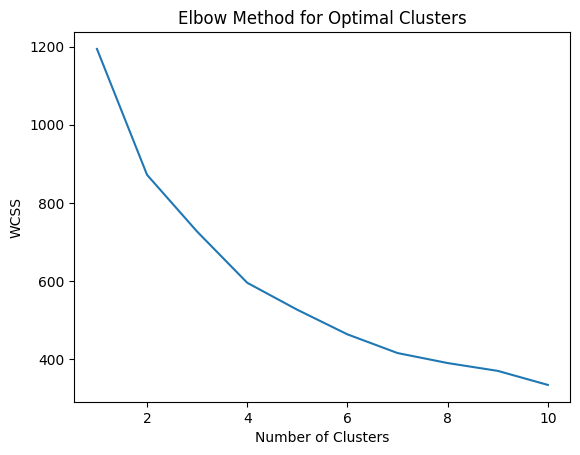

In [120]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate WCSS for different number of clusters
wcss = []
for i in range(1, 11):  # For 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data2)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS value

# Plotting the Elbow curve
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

**Using silhoutee score**

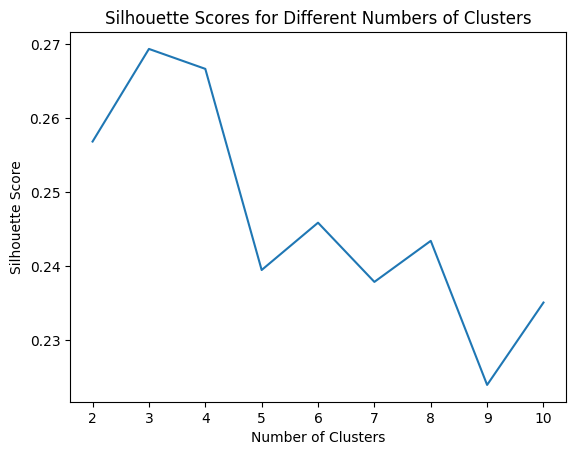

In [121]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for i in range(2, 11):  # Starting from 2 clusters (since silhouette score is undefined for 1 cluster)
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data2)
    score = silhouette_score(scaled_data2, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting the Silhouette scores
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

The silhoutee score for **rfm** ranges from 0 to 0.15 which shows poor clustering

**rfm2** gave a better silhoutee score than rfm

**Going ahead with n=3 and rfm2**

In [122]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

**2. DBSCAN**

In [123]:
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
dbscan_labels = dbscan.fit_predict(scaled_data2)

# Add cluster labels to the original dataframe
rfm2['Cluster'] = dbscan_labels

# Inspect results
print(rfm2[['CustomerID', 'Cluster']].head())

# Count clusters
print("Number of clusters (excluding noise):", len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0))
print("Number of noise points:", list(dbscan_labels).count(-1))

  CustomerID  Cluster
0      C0001       -1
1      C0002       -1
2      C0003       -1
3      C0004       -1
4      C0005       -1
Number of clusters (excluding noise): 1
Number of noise points: 187


**We didnt get a good result using DBSCAN because of large noise**

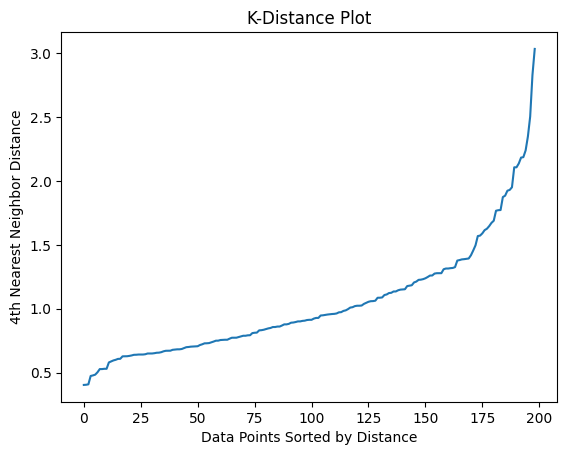

In [124]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=4)  # min_samples = 4
neighbors_fit = neighbors.fit(scaled_data2)
distances, _ = neighbors_fit.kneighbors(scaled_data2)

distances = np.sort(distances[:, 3])  # Sort distances to the 4th nearest neighbor
plt.plot(distances)
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.title('K-Distance Plot')
plt.show()

**Calculation of DBI**

In [137]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data2)

dbi_kmeans = davies_bouldin_score(scaled_data2, kmeans_labels)
print(f"Davies-Bouldin Index for K-Means: {dbi_kmeans:.3f}")




Davies-Bouldin Index for K-Means: 1.019


DBI using scaled data - 2.4

**DBI using scaled data 2- 1.14**

DBI using scaled data 3 - 1.18

***Best results so far- through rfm2 dataframe and n-clusters=4***

**After removing the average_spending feature from rfm2, i god a better DBIndex (1.019) at n=7**

# Final model Evaluation

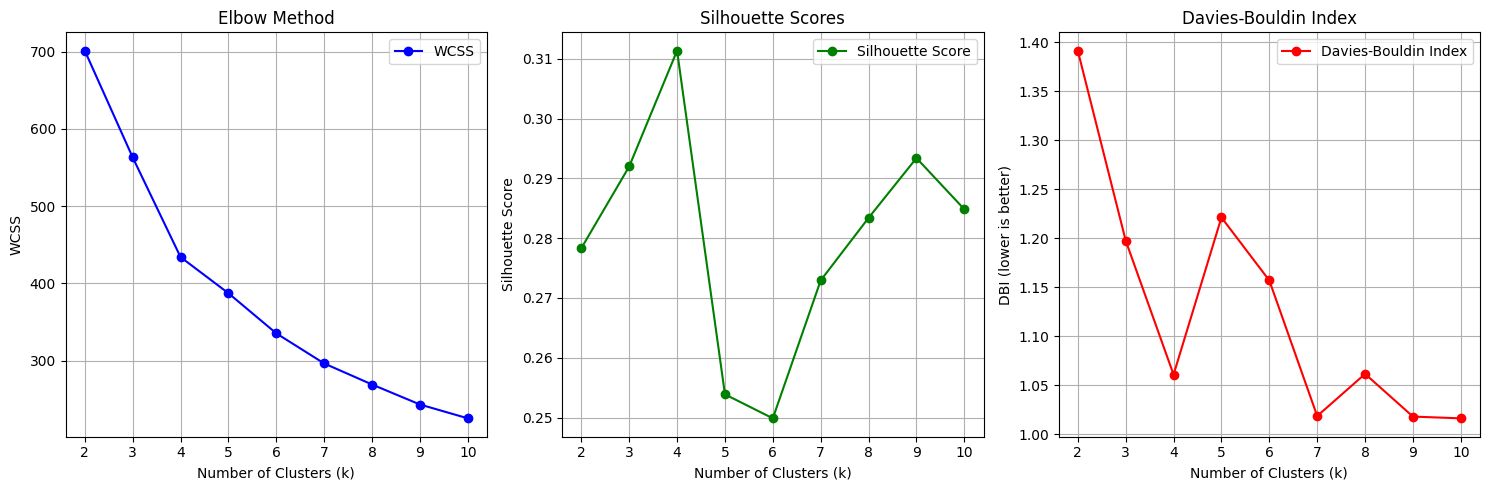

Optimal k based on Silhouette Score: 4
Optimal k based on Davies-Bouldin Index: 10


In [131]:
data = scaled_data2

wcss = []
silhouette_scores = []
dbi_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data)


    wcss.append(kmeans.inertia_)


    silhouette = silhouette_score(data, labels)
    silhouette_scores.append(silhouette)

    dbi = davies_bouldin_score(data, labels)
    dbi_scores.append(dbi)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(k_range, wcss, 'o-', label='WCSS', color='blue')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'o-', label='Silhouette Score', color='green')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(k_range, dbi_scores, 'o-', label='Davies-Bouldin Index', color='red')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DBI (lower is better)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_dbi = k_range[np.argmin(dbi_scores)]

print(f"Optimal k based on Silhouette Score: {optimal_k_silhouette}")
print(f"Optimal k based on Davies-Bouldin Index: {optimal_k_dbi}")

In [142]:
kmeans = KMeans(n_clusters=7, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(scaled_data2)
rfm_with_customer_ids = pd.concat([customer_ids, rfm[['Cluster']]], axis=1)

In [143]:
rfm_with_customer_ids['Cluster'].value_counts()

,count
Cluster,
1,54
0,37
4,28
3,27
6,22
5,19
2,12


**Final model- Kmeans using `n_clusters` and `rfm2 `dataframe**

# Cluster Visualisation

**1. PCA**

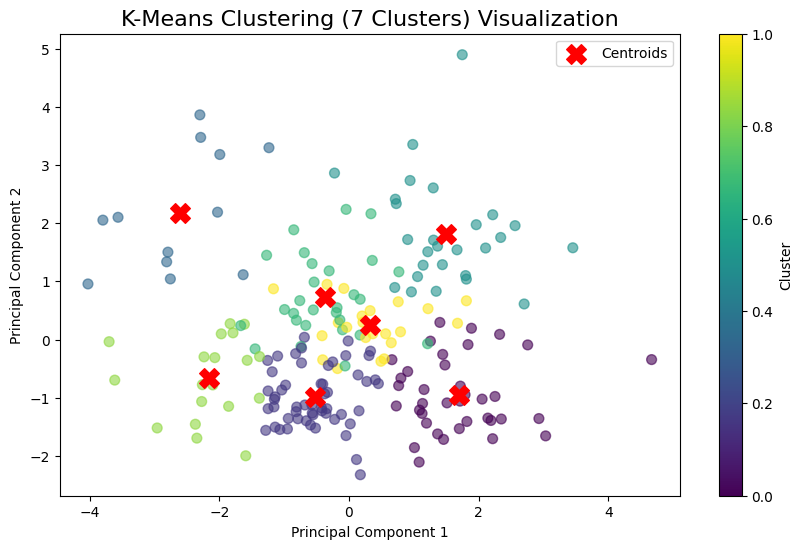

In [144]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data2)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.6)
plt.title('K-Means Clustering (7 Clusters) Visualization', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.legend()
plt.colorbar(label='Cluster')
plt.show()


**2.t-SNE**

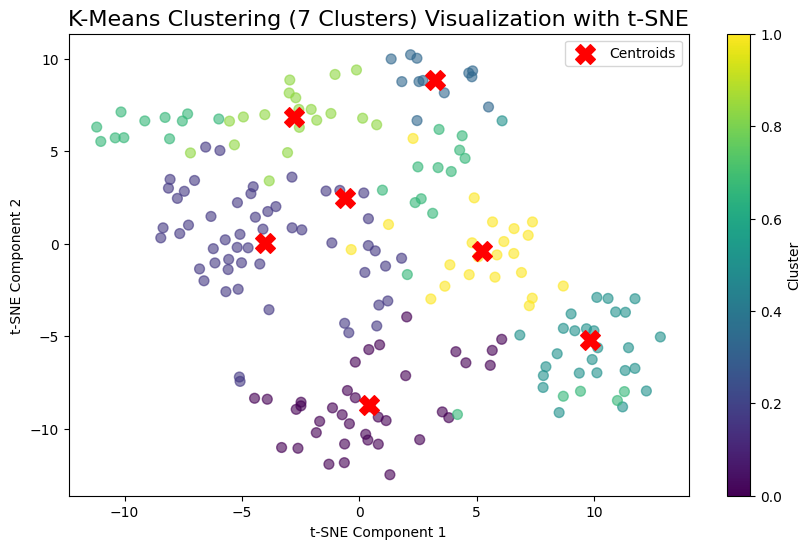

In [146]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(scaled_data2)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.6)
plt.title('K-Means Clustering (7 Clusters) Visualization with t-SNE', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

centers_tsne = []
for i in range(kmeans.n_clusters):
    cluster_points = reduced_data_tsne[kmeans_labels == i]
    center_tsne = cluster_points.mean(axis=0)
    centers_tsne.append(center_tsne)

centers_tsne = np.array(centers_tsne)
plt.scatter(centers_tsne[:, 0], centers_tsne[:, 1], c='red', marker='X', s=200, label='Centroids')

# Show the plot
plt.legend()
plt.colorbar(label='Cluster')
plt.show()